In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import glob
import random
import subprocess

#from tqdm.autonotebook import tqdm

## Patients table

In [2]:
'''
'Crohn disease': K50
'Ulcerative colitis': K51
'Type II diabetes': E11
'Breast cancer (selected using MutPanning26)': C50? Malignant neoplasms of breast
'''

diseases = [
    ('crohn', 'K50'),
    ('ulcerative_colitis', 'K51'),
    ('type_ii_diabetes', 'E11'),
    ('breast_cancer', 'C50')
]

In [3]:
'''
with open('test.csv', 'w') as f:
    cat = subprocess.Popen(["cat", "/home/vasikam/ukb_public_diagnoses.csv"],
                           stdout=subprocess.PIPE)
    hd = subprocess.Popen(["wc"], stdin=cat.stdout, stdout=f)
    
with open("test.txt", "w") as f:
    a = subprocess.Popen(["echo", "e\nsd"], stdout=subprocess.PIPE)
    b = subprocess.Popen(["head", "-c", "2"], stdin=a.stdout, stdout=f)
''' 
''
# for some reason i was unable to get this working, hence the following cell

''

In [4]:
for disease, ICD in diseases:
    output_filename = f'../patients-csvs/{disease}_patients.csv'
    !cat ../ukbiobank_link/tables/ukb_public_diagnoses.csv | head -n 1 > $output_filename
    !cat ../ukbiobank_link/tables/ukb_public_diagnoses.csv | grep $ICD >> $output_filename

cat: write error: Broken pipe
cat: write error: Broken pipe
cat: write error: Broken pipe
cat: write error: Broken pipe


In [5]:
patients_df = {}
for disease, ICD in diseases:
    csv_filename = f'../patients-csvs/{disease}_patients.csv'
    patients_df[disease] = pd.read_csv(csv_filename)
    print(patients_df[disease].head(3))

       eid  diagnosis_number diagnosis              diagnosis_date  \
0  1002586                 8      K500  2015-03-26 00:00:00.000000   
1  1006327                16      K501  2014-06-19 00:00:00.000000   
2  1006327                17      K509  2019-02-17 00:00:00.000000   

  icd_classification  
0              ICD10  
1              ICD10  
2              ICD10  
       eid  diagnosis_number diagnosis              diagnosis_date  \
0  1000871                 6      K513  2010-10-21 00:00:00.000000   
1  1000871                 7      K519  2001-07-31 00:00:00.000000   
2  1001144                 1      K519  2013-09-27 00:00:00.000000   

  icd_classification  
0              ICD10  
1              ICD10  
2              ICD10  
       eid  diagnosis_number diagnosis              diagnosis_date  \
0  1000101                 0      E119  2020-03-18 00:00:00.000000   
1  1000174                 0      E119  2012-04-11 00:00:00.000000   
2  1000193                 1      E119  2005

In [6]:
for disease, ICD in diseases:
    print(disease, np.unique(patients_df[disease]['diagnosis'].values))

crohn ['K500' 'K501' 'K508' 'K509']
ulcerative_colitis ['K510' 'K511' 'K512' 'K513' 'K514' 'K515' 'K518' 'K519']
type_ii_diabetes ['E110' 'E111' 'E112' 'E113' 'E114' 'E115' 'E116' 'E117' 'E118' 'E119']
breast_cancer ['C500' 'C501' 'C502' 'C503' 'C504' 'C505' 'C506' 'C508' 'C509']


In [7]:
disease_eids = {}
for disease, ICD in diseases:
    csv_filename = f'../patients-csvs/{disease}_patients.csv'
    disease_eids[disease] = pd.read_csv(csv_filename)['eid'].values
    print(len(disease_eids[disease]), len(set(disease_eids[disease])))
    
# These results show that eids repeat
# One patients can have several codes from one group (e.g. K500+K508)

4216 2832
7196 5211
45504 38993
20980 17241


In [8]:
disease_eids = {}
vcf_cols = {}
for disease, ICD in diseases:
    csv_filename = f'../patients-csvs/{disease}_patients.csv'
    disease_eids[disease] = set(pd.read_csv(csv_filename)['eid'].values)
    #vcf_cols[disease] = [str(i) + '_' + str(i) for i in disease_eids[disease]]
    #diabetes_eids
    print(disease, len(disease_eids[disease]), list(disease_eids[disease])[:3], sep='\t')

crohn	2832	[2506753, 5513220, 5627913]
ulcerative_colitis	5211	[2621447, 3276807, 3833870]
type_ii_diabetes	38993	[4063233, 5767170, 5898249]
breast_cancer	17241	[1998853, 4456453, 3506187]


## VCFs

In [9]:
chroms = list(range(1, 23)) + ['X', 'XY', 'Y', 'MT']

### playing with stuff

In [10]:
test_ensure_equal_patients = False
if test_ensure_equal_patients:
    patients_for_chr = {}
    for n_chr in chroms:
        vcf_filename = f'../ukbiobank_link/raw_data/ukb22418_c{n_chr}_b0_v2.vcf'
        r = pd.read_csv(
            vcf_filename,
            skiprows=range(6), 
            sep='\t',
            chunksize=1
        )
        patients_for_chr[n_chr] = [s[:len(s)//2] for s in next(r).columns[9:]]
        print(f"appended chr {n_chr} patients")
    
    print([i == patients_for_chr[1] for _, i in patients_for_chr.items()])
    assert [i == patients_for_chr[1] for _, i in patients_for_chr.items()] == [True]*26

### Patients sampling

In [11]:
smallest_vcf_location = "../biobank_extracted/extracted_snps_c6_w500.vcf"

r = pd.read_csv(
    smallest_vcf_location, 
    skiprows=range(6), 
    #usecols=['5825360_5825360', '5467150_5467150'],
    sep='\t',
    chunksize=1
)

In [ ]:
one_row = next(r)
first_cols = list(one_row.columns[:9])
one_row

In [ ]:
first_cols

In [13]:
patients_stat_table = pd.DataFrame(index=(disease for disease, _ in diseases),
                                   columns=['all', 'healthy', 'ill', 'missing in vcf'])

vcf_all_eids = {int(s[:len(s)//2]) for s in one_row.columns[9:]}
healthy_eids = {}
missing_eids = {}
disease_used_eids = {}

for disease, ICD in diseases:
    healthy_eids[disease] = vcf_all_eids - disease_eids[disease]
    missing_eids[disease] = disease_eids[disease] - vcf_all_eids
    disease_used_eids[disease] = disease_eids[disease] - missing_eids[disease]
    
    patients_stat_table['all'][disease] = len(vcf_all_eids)
    patients_stat_table['healthy'][disease] = len(healthy_eids[disease])
    patients_stat_table['ill'][disease] = len(disease_used_eids[disease])
    patients_stat_table['missing in vcf'][disease] = len(missing_eids[disease])  # those that are found in ICD data, but not in genotype data
    
    
#patients_stat_table['sum'] = patients_stat_table['healthy'] + patients_stat_table['ill'] + 0*patients_stat_table['missing in vcf']
patients_stat_table

,all,healthy,ill,missing in vcf
crohn,488377,485647,2730,102
ulcerative_colitis,488377,483310,5067,144
type_ii_diabetes,488377,450775,37602,1391
breast_cancer,488377,471997,16380,861


In [14]:
disease_cols = {}
healthy_cols = {}

for disease, ICD in diseases:
    disease_cols[disease] = [str(x) + '_' + str(x) for x in disease_used_eids[disease]]
    healthy_cols[disease] = [str(x) + '_' + str(x) for x in healthy_eids[disease]]

    print(len(disease_cols[disease]), len(healthy_cols[disease]), disease)

2730 485647 crohn
5067 483310 ulcerative_colitis
37602 450775 type_ii_diabetes
16380 471997 breast_cancer


In [22]:
for trait, ICD in diseases:
    pheno_filename = f'../patients-csvs/{trait}_patients.pheno'
    with open(pheno_filename, 'w') as out_file:
        for healthy_eid in healthy_eids[trait]:
            print(healthy_eid, healthy_eid, "1", sep='\t', file=out_file)
        for disease_eid in disease_used_eids[trait]:
            print(disease_eid, disease_eid, "2", sep='\t', file=out_file)

### Taking SNPs


#### Older try (deleted)


grepping lists of SNP IDs from full vcf files (cMT here):
```
echo $(date) && cat ../ukbiobank_link/raw_data/ukb22418_cMT_b0_v2.vcf | tail -n +7 | grep -o -P "^([^\t]*\t){8}[^\t]*" > biobank_snps_chrMT.vcf && echo $(date)
```



(base) vasikam@Sydney:~$ wc -l ../ukbiobank_link/raw_data/ukb22418_c6_b0_v2.vcf\

53702 ../ukbiobank_link/raw_data/ukb22418_c6_b0_v2.vcf


#### Better try, with the power of PLINK!

SNPs are chosen with `asbs_near_eqtls.py`.


##### SNPs from different size windows

In [15]:
window_sizes = [500 * 2**i for i in range(16)]

In [16]:
all_biobank_snps = np.array([])
for ch in chroms:
    #pd.read_csv(f'../biobank_snps_chr{ch}.vcf', sep='\t')
    all_biobank_snps = np.hstack([all_biobank_snps,  pd.read_csv(f'../biobank_grepped_snp_ids/biobank_snps_chr{ch}.vcf', sep='\t')['ID'].values])
all_biobank_snps.shape, all_biobank_snps

((805426,),
 array(['rs28659788', 'rs116587930', 'rs116720794', ..., 'Affx-79443532',
        'Affx-89025709', 'Affx-79381726'], dtype=object))

In [17]:
for trait, _ in diseases:
    for wsize in window_sizes:
        # Do we need _woheaders anymore?
        with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05.txt', 'r') as in_f:
            with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05_woheaders.txt', 'w') as out_f:
                for line in in_f.readlines():
                    if line[:4] != "ASBs":
                        out_f.write(line)
                        
        with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05.txt', 'r') as in_f:
            with open(f'asbs_near_eqtls/{trait}/w{wsize}_p0.05_snp_ids_list.txt', 'w') as out_f:
                for line in in_f.readlines():
                    if line[:4] != "ASBs":
                        out_f.write(line.split('\t')[3]+'\n')

In [18]:
PLINK_EXEC_PATH = "../plink_linux_x86_64_20220402/plink"
for trait, _ in diseases:
    print(trait)
    for wsize in window_sizes:
        print(f"Exit codes for window size {wsize}:")
        exit_codes = {chrom: [] for chrom in chroms}
        for chrom in chroms:
            proc = subprocess.run([PLINK_EXEC_PATH, 
                                   "--bfile", f"../ukbiobank/raw_data/ukb22418_c{chrom}_b0_v2", 
                                   "--extract", f"asbs_near_eqtls/{trait}/w{wsize}_p0.05_snp_ids_list.txt", 
                                   "--recode", "vcf", 
                                   "--out", f"../biobank_extracted/{trait}/extracted_snps_c{chrom}_w{wsize}"],
                                 capture_output=True)

            if proc.returncode != 0:  # 12: No variants remaining after --extract??
                #print(f"PLINK returned exit code {proc.returncode} for c{chrom} and wsize={wsize}")
                pass
            else:
                #print(f"PLINK returned 0 for c{chrom} and wsize={wsize}")
                pass
            
            exit_codes[chrom] = proc.returncode
        print(exit_codes)

crohn
Exit codes for window size 500:
{1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 12, 11: 12, 12: 12, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 12, 19: 12, 20: 12, 21: 12, 22: 12, 'X': 12, 'XY': 12, 'Y': 12, 'MT': 12}
Exit codes for window size 1000:
{1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 12, 11: 12, 12: 12, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 12, 19: 12, 20: 12, 21: 12, 22: 12, 'X': 12, 'XY': 12, 'Y': 12, 'MT': 12}
Exit codes for window size 2000:
{1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 12, 11: 12, 12: 12, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 12, 19: 12, 20: 12, 21: 12, 22: 12, 'X': 12, 'XY': 12, 'Y': 12, 'MT': 12}
Exit codes for window size 4000:
{1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 12, 7: 12, 8: 12, 9: 12, 10: 12, 11: 12, 12: 12, 13: 12, 14: 12, 15: 12, 16: 12, 17: 12, 18: 12, 19: 12, 20: 12, 21: 12, 22: 12, 'X': 12, 'XY': 12, 'Y': 12, 'MT': 12}
Exit codes for window size 8000:
{1: 12

In [32]:
#for wsize in window_sizes:
#    print(*glob.glob(f'../biobank_extracted/extracted_snps_c*_w{wsize}.vcf'), end='\n\n', sep='\n')

In [ ]:
#wsize = 64000
'''for trait, _ in diseases:
    print(trait)
    variants_dfs = {wsize: pd.DataFrame() for wsize in window_sizes}
    for wsize in window_sizes:
        for filename in glob.glob(f'../biobank_extracted/{trait}/extracted_snps_c*_w{wsize}.vcf'):
            df = pd.read_csv(
                filename,
                skiprows=range(6),
                sep='\t',
                usecols=first_cols + healthy_cols[disease] + disease_cols[disease],
                dtype={'ID': str},
            )
            #print(df)
            variants_dfs[wsize] = pd.concat([variants_dfs[wsize], df], ignore_index=True)


        print(wsize, variants_dfs[wsize].shape)'''

In [ ]:
#wsize = 64000

for trait, _ in diseases:
    print(trait)
    variants_dfs_allpatients = {wsize: pd.DataFrame() for wsize in window_sizes}
    for wsize in window_sizes:
        for filename in glob.glob(f'../biobank_extracted/{trait}/extracted_snps_c*_w{wsize}.vcf'):
            df = pd.read_csv(
                filename,
                skiprows=range(6),
                sep='\t',
                #usecols=first_cols + healthy_cols + diabetes_cols,
                dtype={'ID': str},
            )
            #print(df)
            variants_dfs_allpatients[wsize] = pd.concat([variants_dfs_allpatients[wsize], df], ignore_index=True)


        print(wsize, variants_dfs_allpatients[wsize].shape)

crohn
500 (0, 0)
1000 (0, 0)
2000 (0, 0)
4000 (0, 0)
8000 (0, 0)
16000 (0, 0)
32000 (0, 0)
64000 (0, 0)
128000 (0, 0)
256000 (0, 0)
512000 (0, 0)
1024000 (0, 0)
2048000 (0, 0)
4096000 (0, 0)
8192000 (0, 0)
16384000 (0, 0)
ulcerative_colitis
500 (0, 0)
1000 (0, 0)
2000 (0, 0)
4000 (0, 0)
8000 (0, 0)
16000 (0, 0)
32000 (0, 0)
64000 (0, 0)
128000 (0, 0)
256000 (0, 0)
512000 (0, 0)
1024000 (0, 0)
2048000 (0, 0)
4096000 (0, 0)
8192000 (0, 0)
16384000 (0, 0)
type_ii_diabetes
500 (0, 0)
1000 (0, 0)
2000 (0, 0)
4000 (0, 0)
8000 (0, 0)
16000 (0, 0)
32000 (0, 0)
64000 (0, 0)
128000 (1, 488386)
256000 (2, 488386)
512000 (3, 488386)
1024000 (7, 488386)
2048000 (10, 488386)
4096000 (13, 488386)
8192000 (22, 488386)
16384000 (36, 488386)
breast_cancer
500 (15, 488386)
1000 (17, 488386)
2000 (21, 488386)
4000 (26, 488386)
8000 (26, 488386)
16000 (28, 488386)
32000 (37, 488386)
64000 (44, 488386)
128000 (54, 488386)
256000 (70, 488386)
512000 (98, 488386)
1024000 (145, 488386)
2048000 (226, 488386)
40

In [40]:
'''variants_dfs = {wsize: pd.DataFrame() for wsize in window_sizes}
for wsize in window_sizes:
    variants_dfs[wsize] = variants_dfs_allpatients[wsize][first_cols + healthy_cols + diabetes_cols]
    print(wsize, variants_dfs[wsize].shape)
''' 

500 (1, 75213)
1000 (1, 75213)
2000 (1, 75213)
4000 (1, 75213)
8000 (1, 75213)
16000 (1, 75213)
32000 (1, 75213)
64000 (3, 75213)
128000 (6, 75213)
256000 (7, 75213)
512000 (8, 75213)
1024000 (13, 75213)
2048000 (20, 75213)
4096000 (25, 75213)
8192000 (40, 75213)
16384000 (57, 75213)


In [ ]:
for trait, _ in diseases:
    print(trait)
    wsizes = [500 * 2**i for i in range(16)]  # 16
    asbs_in_window = []
    for wsize in wsizes:
        snps = pd.read_csv(f'../asbs_near_eqtls_oldv4/w{wsize}_p0.05_woheaders.txt', sep='\t', header=None)[3].values
        asbs_in_window.append(len(snps))
        print(wsize, len(snps), len(set(snps) & set(all_biobank_snps)), sep='\t')

Text(0, 0.5, 'relative ASB abundance')

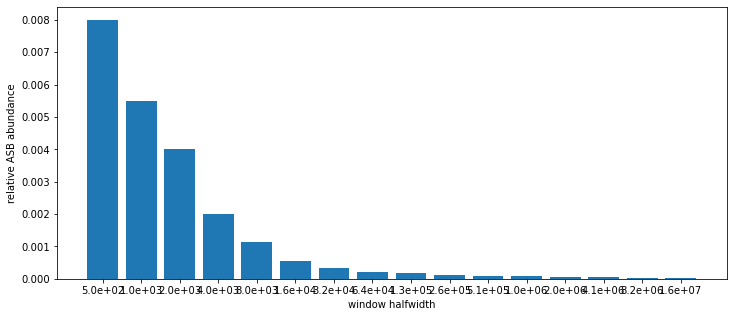

In [19]:
fig = plt.figure(figsize=(12, 5))
rel_counts = [asbs_in_window[i] / (2 * wsizes[i]) for i in range(len(wsizes))]
plt.bar([f'{x:.1e}' for x in wsizes], rel_counts)
plt.xlabel('window halfwidth')
plt.ylabel('relative ASB abundance')

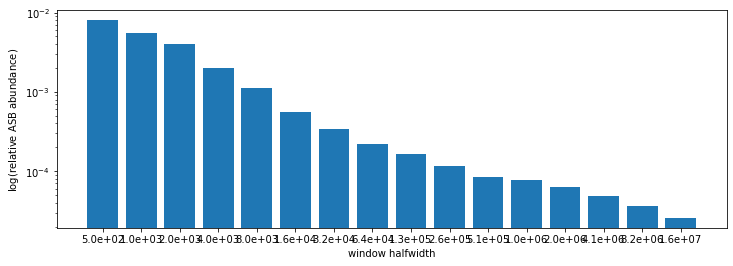

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
#fig, ax = plt.subplots(1, 1, figsize=(36, 15))
rel_counts = [asbs_in_window[i] / (2 * wsizes[i]) for i in range(len(wsizes))]
plt.bar([f'{x:.1e}' for x in wsizes], rel_counts)
plt.xlabel('window halfwidth')
plt.ylabel('$\log($relative ASB abundance$)$')
ax.set_yscale(matplotlib.scale.LogScale(ax))
plt.savefig('rel_ASB_abund.png')

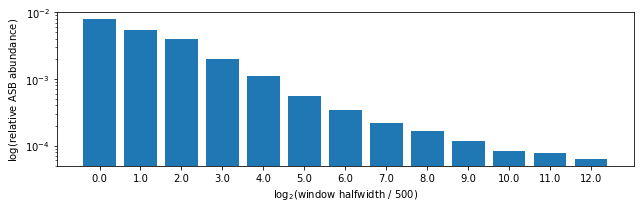

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
#fig, ax = plt.subplots(1, 1, figsize=(36, 15))
rel_counts = [asbs_in_window[i] / (2 * wsizes[i]) for i in range(len(wsizes))]
plt.bar([f'{i:.1f}' for i in range(len(wsizes))], rel_counts)
plt.xlabel('$\log_2$(window halfwidth / 500)')
plt.ylabel('$\log($relative ASB abundance$)$')
ax.set_yscale(matplotlib.scale.LogScale(ax))
plt.tight_layout()
plt.savefig('rel_ASB_abund.png')

In [75]:
pd.read_csv(f'../biobank_snps_chr18.vcf', sep='\t')

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
0,18,11358,rs77459974,G,A,.,.,PR,GT
1,18,47892,Affx-89018553,CTGCCCCGGCTGGTCAG,C,.,.,PR,GT
2,18,48630,rs56260713,G,C,.,.,PR,GT
3,18,48951,Affx-89015884,TTGTC,T,.,.,PR,GT
4,18,49056,Affx-89020160,TG,T,.,.,PR,GT
...,...,...,...,...,...,...,...,...,...
21957,18,78005160,Affx-80259243,C,T,.,.,PR,GT
21958,18,78007784,rs12970236,C,T,.,.,PR,GT
21959,18,78009148,rs117483780,G,A,.,.,PR,GT
21960,18,78010620,rs75887571,C,T,.,.,PR,GT


In [8]:
a = pd.DataFrame()
snps = pd.read_csv(f'../asbs_near_eqtls/w{2048000}_p0.05_woheaders.txt', sep='\t', header=None)[3].values
#print(set(snps) & set(all_biobank_snps))
for ch in chroms:
    df = pd.read_csv(f'../biobank_snps_chr{ch}.vcf', sep='\t')
    #[i for i in df['ID'].values if i in ['rs17257408', 'rs13064699']]
    #print([i for i in df['ID'].values if i in snps])
    for i, row in df.iterrows():
        #print(df.iloc[i:i+1, :])
        #break
        if row['ID'] in snps:
            a = pd.concat([a, df.iloc[i:i+1, :]])
a

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
36642,1,156341494,rs7525133,G,A,.,.,PR,GT
36995,1,157062739,rs12136960,C,G,.,.,PR,GT
37040,1,157210709,rs6672275,G,A,.,.,PR,GT
37089,1,157375579,rs4483398,A,C,.,.,PR,GT
40638,1,167845787,rs6427113,T,C,.,.,PR,GT
1897,4,4990298,rs4450871,A,G,.,.,PR,GT
3070,4,6893308,rs9992789,A,C,.,.,PR,GT
3249,4,7219933,rs4234798,G,T,.,.,PR,GT
12424,6,30029109,rs7770557,C,G,.,.,PR,GT
13378,6,30685547,rs115321330,G,T,.,.,PR,GT


In [17]:
r = pd.read_csv(
    '../ukbiobank_link/raw_data/ukb22418_c18_b0_v2.vcf', 
    #'../ukb22418_cMT_b0_v2-copy.vcf', 
    skiprows=lambda x: x not in [6, 5713, 5714, 5715, 6238, 6239, 6240,11285, 11286,11287,11288,11289,11290,11291,11292, 11293, 11294, 11295, 11296,11297, 11298,11299], 
    #usecols=first_cols ,#+ healthy_cols + diabetes_cols,
    usecols=['ID'],
    sep='\t',
    chunksize=50,
    dtype={'ID': str},
)

In [ ]:
tqdm()

In [18]:
a = next(r)


In [19]:
a

,ID
0,rs117622637
1,rs1893250
2,rs948383
3,rs11659802
4,rs28683728
5,rs75266721
6,rs4890637
7,rs16978537
8,rs78526649
9,rs7230860


In [17]:
!ls ../

all_E11.csv		biobank_snps_chr3.vcf
asbs_near_eqtls		biobank_snps_chr4.vcf
biobank_snps_chr10.vcf	biobank_snps_chr5.vcf
biobank_snps_chr11.vcf	biobank_snps_chr6.vcf
biobank_snps_chr12.vcf	biobank_snps_chr7.vcf
biobank_snps_chr13.vcf	biobank_snps_chr8.vcf
biobank_snps_chr14.vcf	biobank_snps_chr9.vcf
biobank_snps_chr15.vcf	biobank_snps_chrMT.vcf
biobank_snps_chr16.vcf	biobank_snps_chrX.vcf
biobank_snps_chr17.vcf	biobank_snps_chrXY.vcf
biobank_snps_chr18.vcf	biobank_snps_chrY.vcf
biobank_snps_chr19.vcf	miniconda3
biobank_snps_chr1.vcf	Miniconda3-latest-Linux-x86_64.sh
biobank_snps_chr20.vcf	py-notebooks
biobank_snps_chr21.vcf	trimmed.vcf
biobank_snps_chr22.vcf	ukb22418_cMT_b0_v2-copy.vcf
biobank_snps_chr2.vcf	vcf_line.vcf


##### Extracting SNPs from biobank with PLINK

## Logistic Regression

In [39]:
#import sklearn

In [19]:
from sklearn.linear_model import LogisticRegression  #other?
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [20]:
Xs = {}
for wsize, df in variants_dfs.items():
    #print(wsize)
    #pass
    Xs[wsize] = variants_dfs[wsize].set_index(variants_dfs[wsize]['ID'].values).drop(columns=first_cols).T
    Xs[wsize] = pd.get_dummies(Xs[wsize])

In [24]:
Xs[2000]

,rs7770557_./.,rs7770557_0/0,rs7770557_0/1,rs7770557_1/1
2658515_2658515,0,1,0,0
5418788_5418788,0,1,0,0
1410704_1410704,0,1,0,0
5678089_5678089,0,1,0,0
1863781_1863781,0,1,0,0
...,...,...,...,...
2631746_2631746,0,1,0,0
3331715_3331715,0,1,0,0
1874054_1874054,0,1,0,0
5028626_5028626,0,1,0,0


In [27]:
RocCurveDisplay.from_predictions

<bound method RocCurveDisplay.from_predictions of <class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>>

In [82]:
wsize=2048000  #16384000 #8192000 

logreg = LogisticRegression(max_iter=250)

X = Xs[wsize]
y = [int(i in diabetes_cols) for i in X.index.values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:, 1]
rocauc = roc_auc_score(y_test, y_pred)
print(f"w{wsize}: rocauc = {rocauc:.4f}")

w2048000: rocauc = 0.5216


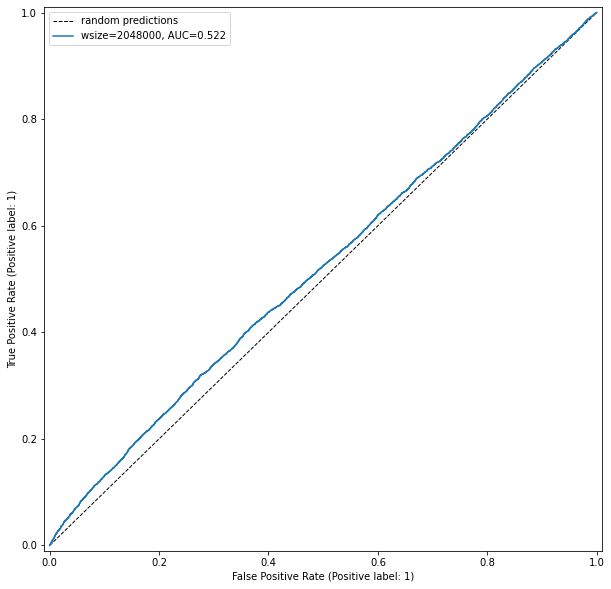

In [83]:
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.plot([0, 1], [0, 1], ls='--', lw=1, c='k')

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.legend(['random predictions', f'wsize={wsize}, AUC={rocauc:.3f}'])

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.savefig('roc_curve_example.png')

KeyboardInterrupt: 

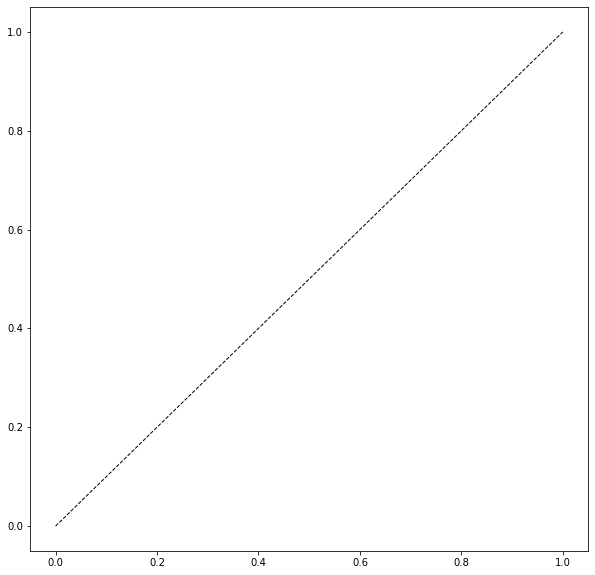

In [21]:
plt.figure(figsize=(10,10))
ax = plt.axes()
plt.plot([0, 1], [0, 1], ls='--', lw=1, c='k')

rocaucs = []
for wsize in window_sizes:
    logreg = LogisticRegression(max_iter=250)
    
    X = Xs[wsize]
    y = [int(i in diabetes_cols) for i in X.index.values]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    logreg.fit(X_train, y_train)
    rocauc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
    rocaucs.append(rocauc)
    print(f"w{wsize}: rocauc = {rocauc:.4f}")
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax)
legend = ['random predictions'] + [f'wsize={wsize}, AUC={rocauc:.3f}' for wsize, rocauc in zip(window_sizes, rocaucs)]
ax.legend(legend)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.show()

In [28]:
np.mean([3])

3.0

In [69]:
rocaucs = {}
for wsize in window_sizes:
    rocaucs[wsize] = []
    for _ in range(25):
        healthy_used_eids = random.sample(list(healthy_eids), len(diabetes_used_eids))
        healthy_cols = [str(x) + '_' + str(x) for x in healthy_used_eids]
        
        
        
        variants_df = variants_dfs_allpatients[wsize][first_cols + healthy_cols + diabetes_cols]
            
        X = variants_dfs[wsize].set_index(variants_dfs[wsize]['ID'].values).drop(columns=first_cols).T
        X = pd.get_dummies(Xs[wsize])
        y = [int(i in diabetes_cols) for i in X.index.values]
    
        
        


        logreg = LogisticRegression(max_iter=500)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        logreg.fit(X_train, y_train)
        rocauc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
        rocaucs[wsize].append(rocauc)
        
        print('.', end='')
        
    print()
    print(f"w{wsize}: rocauc = {np.mean(rocaucs[wsize]):.4f} +- {np.std(rocaucs[wsize], ddof=1):.4f}")

.........................
w500: rocauc = 0.5087 +- 0.0022
.........................
w1000: rocauc = 0.5077 +- 0.0020
.........................
w2000: rocauc = 0.5082 +- 0.0025
.........................
w4000: rocauc = 0.5082 +- 0.0020
.........................
w8000: rocauc = 0.5080 +- 0.0026
.........................
w16000: rocauc = 0.5075 +- 0.0021
.........................
w32000: rocauc = 0.5078 +- 0.0022
.........................
w64000: rocauc = 0.5123 +- 0.0040
.........................
w128000: rocauc = 0.5218 +- 0.0029
.........................
w256000: rocauc = 0.5235 +- 0.0028
.........................
w512000: rocauc = 0.5226 +- 0.0037
.........................
w1024000: rocauc = 0.5252 +- 0.0035
.........................
w2048000: rocauc = 0.5255 +- 0.0041
.........................
w4096000: rocauc = 0.5272 +- 0.0042
.........................
w8192000: rocauc = 0.5411 +- 0.0036
.........................
w16384000: rocauc = 0.5452 +- 0.0038


In [76]:
means = [np.mean(i) for _, i in rocaucs.items()]
stds = [np.std(i, ddof=1) for _, i in rocaucs.items()]
means, stds

([0.5086560273976479,
  0.5077065536174478,
  0.5082368127540908,
  0.5082326428064842,
  0.5080232471291989,
  0.507465457578282,
  0.5078301668305234,
  0.51233389683853,
  0.5218336028182177,
  0.5235164247155264,
  0.5226079840935928,
  0.5251798560499024,
  0.5254556303794695,
  0.5271545225438617,
  0.5411215815614677,
  0.5451738330657725],
 [0.0022265043049717664,
  0.0019868608208275015,
  0.0024602808987920044,
  0.001987899112990431,
  0.0025849958467311796,
  0.0020995765729978294,
  0.002180527276660362,
  0.004033830451106213,
  0.002886557970462429,
  0.002814197535000761,
  0.0036788999650365682,
  0.003451131473002269,
  0.0040840740041853405,
  0.004234564811232111,
  0.003582819134258206,
  0.0038089404464142175])

In [70]:
rocaucs

{500: [0.51024448450299,
  0.5083827497428003,
  0.5059980634824423,
  0.5084643764018707,
  0.506666739853379,
  0.5098455053398403,
  0.5087760626086522,
  0.5121666279275827,
  0.5087246244523748,
  0.5071872867137134,
  0.5094054903009857,
  0.5077962751250676,
  0.5120795324503737,
  0.5065803919667511,
  0.5079497810761531,
  0.5059549772524987,
  0.5088640090799262,
  0.5058599747172267,
  0.5083789727676395,
  0.5116260599298021,
  0.5137800272515425,
  0.5074297394446836,
  0.5076678063951071,
  0.5113277962225417,
  0.5052433299352518],
 1000: [0.5074042321278873,
  0.5094853229689623,
  0.5064281192669479,
  0.5066247793720533,
  0.5105736754375585,
  0.5056426350062002,
  0.5073366021906788,
  0.5075164108961859,
  0.5123585866806637,
  0.5074279394615108,
  0.5085421419389439,
  0.5090232771294224,
  0.5043667595006811,
  0.5096071804349028,
  0.5037990219685722,
  0.5094520287019738,
  0.5090855519476882,
  0.5073003537447606,
  0.5057096432480298,
  0.5068233148499197,
 

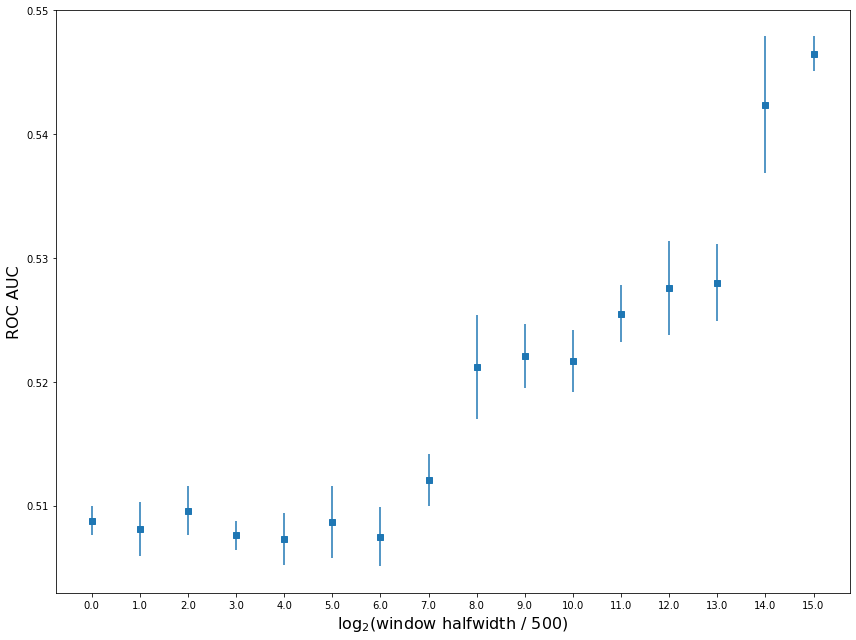

In [67]:
s = '''w500: rocauc = 0.5088 +- 0.0012
w1000: rocauc = 0.5081 +- 0.0022
w2000: rocauc = 0.5096 +- 0.0020
w4000: rocauc = 0.5076 +- 0.0012
w8000: rocauc = 0.5073 +- 0.0021
w16000: rocauc = 0.5087 +- 0.0029
w32000: rocauc = 0.5075 +- 0.0024
w64000: rocauc = 0.5121 +- 0.0021
w128000: rocauc = 0.5212 +- 0.0042
w256000: rocauc = 0.5221 +- 0.0026
w512000: rocauc = 0.5217 +- 0.0025
w1024000: rocauc = 0.5255 +- 0.0023
w2048000: rocauc = 0.5276 +- 0.0038
w4096000: rocauc = 0.5280 +- 0.0031
w8192000: rocauc = 0.5424 +- 0.0055
w16384000: rocauc = 0.5465 +- 0.0014'''.split('\n')
s = np.array([[float(i.split()[-3]), float(i.split()[-1])] for i in s])
s
plt.figure(figsize=(12, 9))
plt.errorbar([f'{i:.1f}' for i in range(16)], s[:, 0], yerr=s[:, 1], ls='', fmt='s')
plt.xlabel('$\log_2$(window halfwidth / 500)', fontsize=16)
plt.ylabel('ROC AUC', fontsize=16)
plt.tight_layout()
plt.savefig('rocaucs.png')


In [ ]:
wsizes = [500 * 2**i for i in range(16)]
vals = {ws: auc for ws, auc in zip(wsizes, [0.]*16) }

for i in range(8):
    print(f"{wsizes[i]} & {vals[wsizes[i]]} & {wsizes[i+8]} & {vals[wsizes[i+8]]} \\\\\\hline")


In [197]:
assert (np.unique(variants_df_T.values) == ['./.', '0/0', '0/1', '1/1']).all()
np.unique(variants_df_T.values)

array(['./.', '0/0', '0/1', '1/1'], dtype=object)

In [198]:
np.sum(variants_df_T.values == './.')

488

In [174]:
# takes around 30-40 secs
y = [int(i in diabetes_cols) for i in variants_df_T.index.values]
print(len(y), '\n', *y[:30])

75204 
 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0


In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [202]:
X_train

,rs7770557_./.,rs7770557_0/0,rs7770557_0/1,rs7770557_1/1,rs115321330_./.,rs115321330_0/0,rs115321330_0/1,rs115321330_1/1,rs1893250_./.,rs1893250_0/0,rs1893250_0/1,rs1893250_1/1
5864019_5864019,0,1,0,0,0,1,0,0,0,1,0,0
3282140_3282140,0,1,0,0,0,1,0,0,0,0,1,0
2154334_2154334,0,1,0,0,0,1,0,0,0,0,1,0
5656831_5656831,0,1,0,0,0,1,0,0,0,0,1,0
5590596_5590596,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2861188_2861188,0,1,0,0,0,1,0,0,0,0,0,1
1039848_1039848,0,1,0,0,0,1,0,0,0,0,1,0
5042100_5042100,0,1,0,0,0,1,0,0,0,0,1,0
3249305_3249305,0,1,0,0,0,1,0,0,0,0,1,0


In [203]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [210]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

0.5158977976373893

In [207]:
logreg.predict_proba(X_test).shape

(18801, 2)